In [1]:
import numpy as np
import scipy.io.wavfile as wav
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import time
import argparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import SparseCoder
from scipy import signal
from scipy.io import wavfile

In [2]:
Path_to_dataset_files =  "/mnt/d_disk/ch22b007/.cache/kagglehub/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech/versions/6"

In [3]:
# import librosa
# import numpy as np
# import glob
# import matplotlib.pyplot as plt

# # Get list of all .wav files in the folder
# file_paths = glob.glob("train_samples/*.wav")

# # Read all wav files and store them in a list
# wav_data = []
# for file in file_paths:
#     data, _ = librosa.load(file, sr=None)  # Keep original sample rate
#     wav_data.append(data)

# # Convert list to a matrix (pad shorter signals with zeros)
# max_length = max(len(x) for x in wav_data)
# wav_matrix = np.array([np.pad(x, (0, max_length - len(x))) for x in wav_data])

# print("WAV Matrix shape:", wav_matrix.shape)  # (num_files, max_length)

import librosa
import numpy as np
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Define the root folder containing multiple subfolders
root_folder = "TRAIN"  # Change this to your folder path

# Recursively get all .wav files from all subdirectories
file_paths = [str(file) for file in Path(root_folder).rglob("*.wav")]

# Read all wav files and store them in a list
min_lgth = 0
wav_data = []
for file in file_paths:
    data, _ = librosa.load(file, sr=None)  # Keep original sample rate
    max_data= np.max(data)
    data /= max_data
    wav_data.append(data)
    
# Convert list to a matrix (pad shorter signals with zeros)
max_length = max(len(x) for x in wav_data)  # Find max length of any audio file
wav_matrix = np.array([np.pad(x, (0, max_length - len(x))) for x in wav_data])

print("Total WAV files found:", len(file_paths))
print("WAV Matrix shape:", wav_matrix.shape)  # (num_files, max_length)

Total WAV files found: 4620
WAV Matrix shape: (4620, 124621)


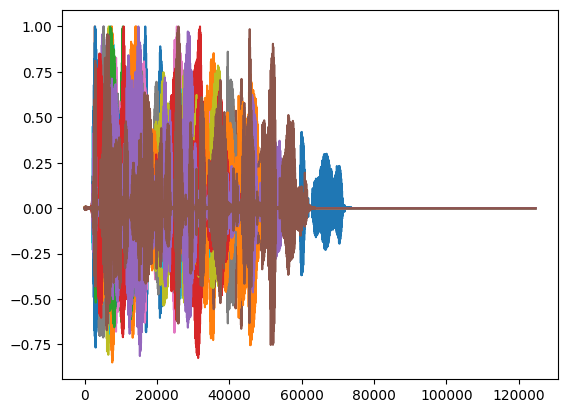

In [4]:
plt.plot(wav_matrix[:16, :].transpose())

In [5]:
np.max(wav_matrix)

1.0

In [6]:
from ksvd import ApproximateKSVD
def test_ksvd(X, n_components):
    """This function finds the dictionary components and also the coefficients"""

    # Apply Approximate K-SVD dictionary learning
    dico = ApproximateKSVD(n_components=n_components, transform_n_nonzero_coefs=8)
    # transform_n_nonzero_coefs = L means that every sample can use at most L nonzero coefficients in its sparse representation.
    dico.fit(X)
    gamma = dico.transform(X)
    return dico.components_, gamma

In [ ]:
# dic, coeffs = test_ksvd(wav_matrix, 16)
dic, coeff = test_ksvd(wav_matrix, 32)


In [ ]:
print(dic.shape, coeff.shape, wav_matrix.shape)

In [ ]:
plt.plot(coeff[:, 0])

In [ ]:
from ksvd import ApproximateKSVD
def test_ksvd1(X, n_components):
    """This function finds the dictionary components and also the coefficients"""

    # Apply Approximate K-SVD dictionary learning
    dico = ApproximateKSVD(n_components=n_components, transform_n_nonzero_coefs=8)
    dico.fit(X)
    gamma = dico.transform(X)
    return dico.components_, gamma

dic1, coeff1 = test_ksvd1(wav_matrix, 32)

In [26]:
import sys
sys.path.append("/mnt/d_disk/ch22b007/mdla")
from mdla import MiniBatchMultivariateDictLearning, MultivariateDictLearning

n_kernels = 10
max_iter = 100
n_nonzero_coefs = 5
n_jobs = 1
learning_rate = 1.5
kernel_init_len = 20
rng_global = np.random.RandomState(1)

learned_dict = MultivariateDictLearning(
        n_kernels=n_kernels,
        max_iter=max_iter,
        verbose=1,
        n_nonzero_coefs=n_nonzero_coefs,
        n_jobs=n_jobs,
        learning_rate=learning_rate,
        kernel_init_len=kernel_init_len,
        dict_init=None,
        random_state=rng_global,
    )

X = wav_matrix[0:10, 0:60000]

learned_dict = learned_dict.fit(X)

ValueError: X should have more n_dims than n_features

In [ ]:
def generate_gammatones(window_size=512, sample_rate=16000, n_filters=16):
    """
    Generate gammatone basis functions similar to Smith & Lewicki paper.
    
    Args:
        window_size: Length of each filter in samples
        sample_rate: Sampling rate
        n_filters: Number of filters to generate
    
    Returns:
        Array of gammatone functions
    """
    print(f"Generating {n_filters} gammatone functions...")
    
    # Frequency range (approximating auditory range)
    min_freq = 100
    max_freq = sample_rate/2
    
    # Generate center frequencies (logarithmic spacing as in auditory system)
    center_freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), n_filters)
    
    gammatones = []
    time = np.arange(window_size) / sample_rate
    
    for fc in center_freqs:
        # Parameters for gammatone - based on auditory filter properties
        n = 4  # Filter order (typical for auditory models)
        b = 1.019 * 24.7 * (4.37 * fc / 1000 + 1)  # Bandwidth parameter (ERB formula)
        
        # Gammatone impulse response formula
        # g(t) = t^(n-1) * exp(-2πbt) * cos(2πfct)
        gamma = time**(n-1) * np.exp(-2*np.pi*b*time) * np.cos(2*np.pi*fc*time)
        
        # Normalize
        gamma = gamma # / (np.max(np.abs(gamma)) + 1e-10)
        
        gammatones.append(gamma)
    
    return np.array(gammatones)

gammatones = generate_gammatones(window_size=102093, sample_rate=16000, n_filters=16)

In [ ]:
plt.plot(dic.transpose())

In [ ]:
plt.plot(gammatones.transpose())
plt.xlim([0, 1000])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import DictionaryLearning
from sklearn.preprocessing import normalize
import pywt

def create_gabor_dictionary(signal_length, num_scales=5, num_frequencies=8, 
                           num_translations=None, normalize_atoms=True):
    """
    Create a Gabor filter dictionary for time series data.
    
    Parameters:
    -----------
    signal_length : int
        Length of the time series signal
    num_scales : int
        Number of scales (widths) for the Gabor filters
    num_frequencies : int
        Number of frequencies for the Gabor filters
    num_translations : int or None
        Number of translations. If None, use signal_length // 4
    normalize_atoms : bool
        Whether to normalize the dictionary atoms
        
    Returns:
    --------
    dictionary : ndarray, shape (n_atoms, signal_length)
        Gabor filter dictionary
    """
    if num_translations is None:
        num_translations = max(signal_length // 4, 1)
    
    # Calculate number of atoms
    n_atoms = num_scales * num_frequencies * num_translations
    
    # Create empty dictionary
    dictionary = np.zeros((n_atoms, signal_length))
    
    # Generate scales logarithmically
    scales = np.logspace(0, 2, num_scales)
    
    # Generate frequencies
    frequencies = np.linspace(0.1, 0.5, num_frequencies)
    
    # Generate translation points
    if num_translations == 1:
        translations = [signal_length // 2]
    else:
        translations = np.linspace(0, signal_length - 1, num_translations).astype(int)
    
    # Time vector
    t = np.arange(signal_length)
    
    # Generate Gabor atoms
    atom_idx = 0
    for scale in scales:
        for freq in frequencies:
            for trans in translations:
                # Create Gabor atom
                gaussian_env = np.exp(-((t - trans) ** 2) / (2 * scale ** 2))
                oscillation = np.cos(2 * np.pi * freq * (t - trans) / signal_length)
                gabor_atom = gaussian_env * oscillation
                
                # Store atom in dictionary
                dictionary[atom_idx] = gabor_atom
                atom_idx += 1
    
    # Normalize dictionary atoms if requested
    if normalize_atoms:
        dictionary = normalize(dictionary, axis=1, norm='l2')
    
    return dictionary

def fit_dictionary_to_timeseries(time_series, dictionary=None, n_components=None, 
                                alpha=1.0, transform_algorithm='lasso_lars'):
    """
    Fit a Gabor dictionary to time series data using dictionary learning.
    
    Parameters:
    -----------
    time_series : ndarray, shape (n_samples, signal_length)
        Input time series data
    dictionary : ndarray or None
        Initial dictionary to start with. If None, a Gabor dictionary is created.
    n_components : int or None
        Number of dictionary atoms to use. If None, use min(n_samples, 2*signal_length)
    alpha : float
        Sparsity controlling parameter
    transform_algorithm : str
        Algorithm for sparse coding
        
    Returns:
    --------
    dictionary : ndarray
        Learned dictionary
    sparse_code : ndarray
        Sparse representation of the input data
    reconstructed : ndarray
        Reconstructed time series using the learned dictionary
    """
    n_samples, signal_length = time_series.shape
    
    # Create Gabor dictionary if not provided
    if dictionary is None:
        if n_components is None:
            n_components = min(n_samples, 2 * signal_length)
        dictionary = create_gabor_dictionary(signal_length, 
                                            num_scales=5, 
                                            num_frequencies=8, 
                                            num_translations=n_components//(5*8))
        
        # If the dictionary is too large, truncate it
        if dictionary.shape[0] > n_components:
            dictionary = dictionary[:n_components]
    
    # Initialize dictionary learning
    dict_learner = DictionaryLearning(
        n_components=n_components or dictionary.shape[0],
        alpha=alpha,
        max_iter=1000,
        transform_algorithm=transform_algorithm,
        fit_algorithm='cd',
        dict_init=dictionary,
        verbose=False
    )
    
    # Fit dictionary and transform data
    sparse_code = dict_learner.fit_transform(time_series)
    
    # Get the learned dictionary
    learned_dictionary = dict_learner.components_
    
    # Reconstruct time series
    reconstructed = sparse_code @ learned_dictionary
    
    return learned_dictionary, sparse_code, reconstructed

def analyze_wavelet_coefficients(time_series, wavelet='morl', scales=None):
    """
    Analyze time series using continuous wavelet transform with Morlet wavelet.
    
    Parameters:
    -----------
    time_series : ndarray
        Input time series (1D)
    wavelet : str
        Wavelet to use, 'morl' (Morlet) is good for Gabor-like analysis
    scales : ndarray or None
        Scales for wavelet transform. If None, use default scales.
        
    Returns:
    --------
    coefficients : ndarray
        Wavelet coefficients
    frequencies : ndarray
        Corresponding frequencies
    """
    if scales is None:
        scales = np.arange(1, 128)
    
    # Perform continuous wavelet transform
    coefficients, frequencies = pywt.cwt(time_series, scales, wavelet)
    
    return coefficients, frequencies

# Example usage
def demo_with_synthetic_data(n_samples=5, signal_length=512):
    """
    Demonstrate Gabor dictionary fitting with synthetic data.
    """
    # Generate synthetic time series data with multiple frequency components
    np.random.seed(42)
    t = np.linspace(0, 1, signal_length)
    
    # Create sample signals with different frequency components
    signals = []
    for _ in range(n_samples):
        # Random frequency components
        freqs = np.random.choice(np.arange(5, 50), size=3)
        amplitudes = np.random.rand(3)
        
        # Create signal with noise
        signal = np.zeros(signal_length)
        for i in range(3):
            signal += amplitudes[i] * np.sin(2 * np.pi * freqs[i] * t)
        
        # Add Gaussian noise
        signal += 0.1 * np.random.randn(signal_length)
        signals.append(signal)
    
    # Stack signals
    time_series = np.vstack(signals)
    
    # Create and fit Gabor dictionary
    dictionary = create_gabor_dictionary(signal_length, 
                                        num_scales=4, 
                                        num_frequencies=6, 
                                        num_translations=10)
    
    learned_dict, sparse_code, reconstructed = fit_dictionary_to_timeseries(
        time_series, dictionary=dictionary, alpha=0.5)
    
    # Calculate reconstruction error
    error = np.mean((time_series - reconstructed) ** 2)
    print(f"Mean squared reconstruction error: {error:.6f}")
    
    # Plot original vs reconstructed signals for the first example
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3, 1, 1)
    plt.title("Original Signal (First Example)")
    plt.plot(time_series[0])
    
    plt.subplot(3, 1, 2)
    plt.title("Reconstructed Signal (First Example)")
    plt.plot(reconstructed[0])
    
    plt.subplot(3, 1, 3)
    plt.title("Reconstruction Error")
    plt.plot(time_series[0] - reconstructed[0])
    
    plt.tight_layout()
    plt.show()
    
    # Display the learned dictionary atoms
    num_atoms_to_display = min(16, learned_dict.shape[0])
    plt.figure(figsize=(12, 8))
    for i in range(num_atoms_to_display):
        plt.subplot(4, 4, i+1)
        plt.plot(learned_dict[i])
        plt.title(f"Atom {i+1}")
        plt.xticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Analyze first signal using wavelet transform for comparison
    coefficients, frequencies = analyze_wavelet_coefficients(time_series[0])
    
    plt.figure(figsize=(10, 6))
    plt.title("Wavelet Coefficients (Scalogram)")
    plt.imshow(np.abs(coefficients), aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Scale')
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()
    
    return dictionary, learned_dict, sparse_code, reconstructed

# For real data usage
def fit_gabor_to_real_timeseries(time_series_data, signal_length=None):
    """
    Fit Gabor dictionary to real time series data.
    
    Parameters:
    -----------
    time_series_data : ndarray, 1D or 2D
        Input time series data. If 1D, it will be reshaped to 2D.
    signal_length : int or None
        Length to reshape the signal. If None, use the original length.
    
    Returns:
    --------
    Dictionary fitting results.
    """
    # Reshape time series if necessary
    if time_series_data.ndim == 1:
        if signal_length is None:
            signal_length = len(time_series_data)
        
        # Calculate how many samples we can extract
        n_samples = len(time_series_data) // signal_length
        
        # Reshape the data
        reshaped_data = np.array([
            time_series_data[i*signal_length:(i+1)*signal_length] 
            for i in range(n_samples)
        ])
    else:
        reshaped_data = time_series_data
    
    # Create and fit Gabor dictionary
    dictionary = create_gabor_dictionary(
        reshaped_data.shape[1], 
        num_scales=5, 
        num_frequencies=8, 
        num_translations=10
    )
    
    learned_dict, sparse_code, reconstructed = fit_dictionary_to_timeseries(
        reshaped_data, dictionary=dictionary, alpha=0.5
    )
    
    return dictionary, learned_dict, sparse_code, reconstructed

if __name__ == "__main__":
    # Run the demo
    demo_with_synthetic_data()

Mean squared reconstruction error: 0.000031


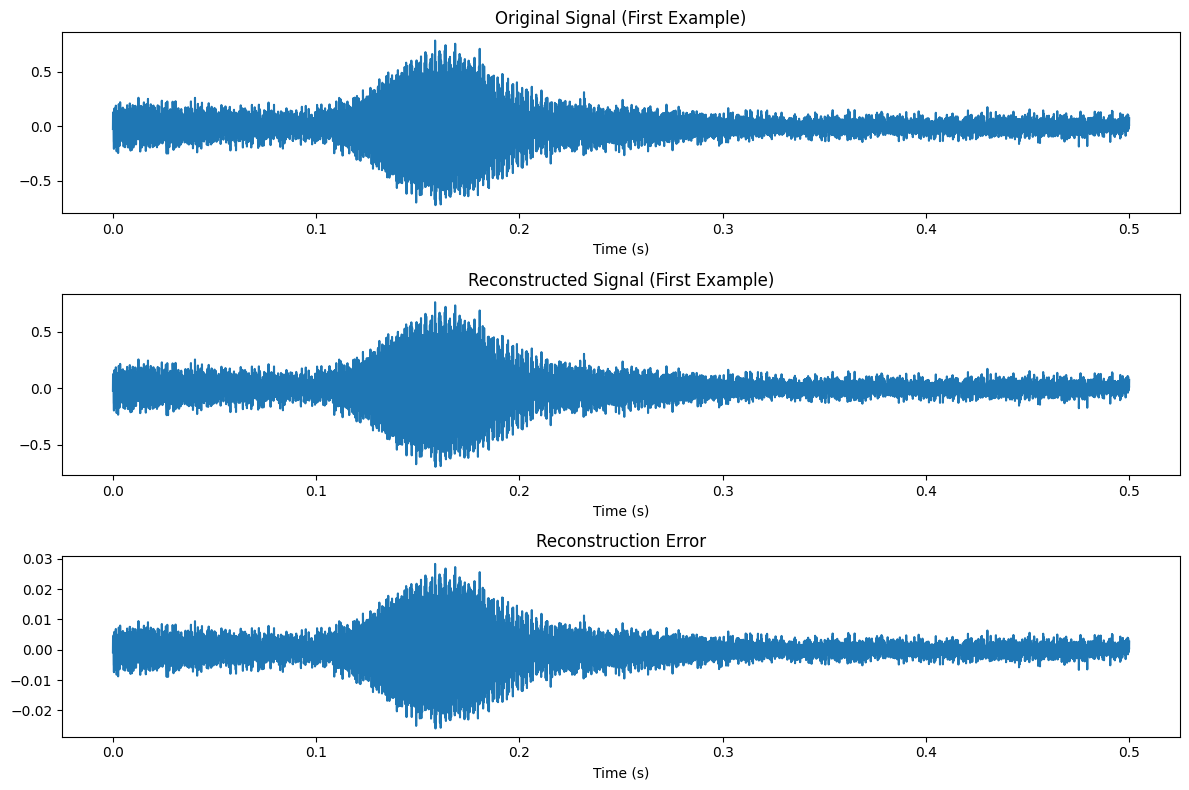

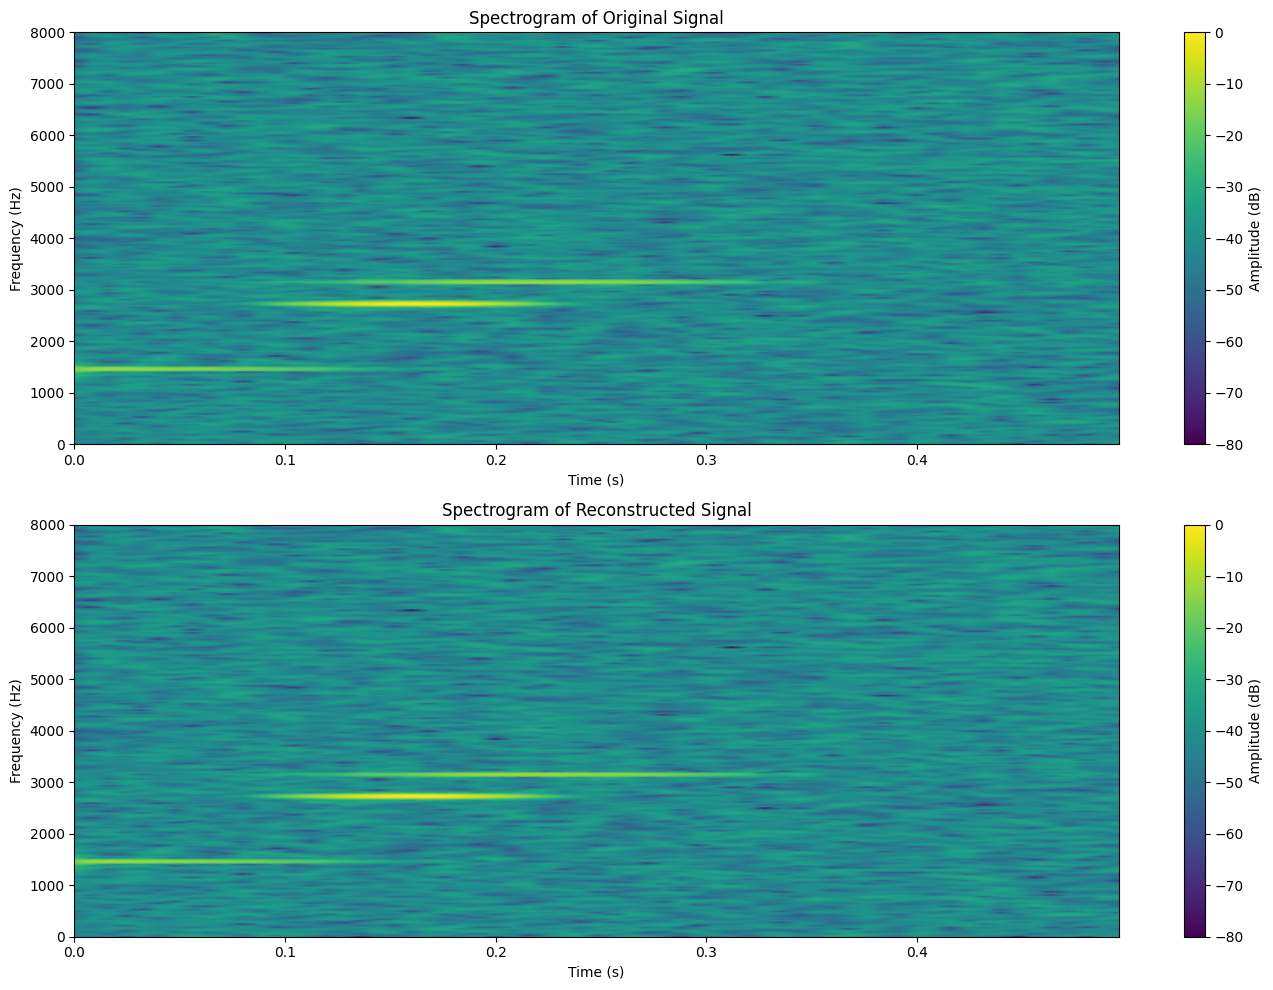

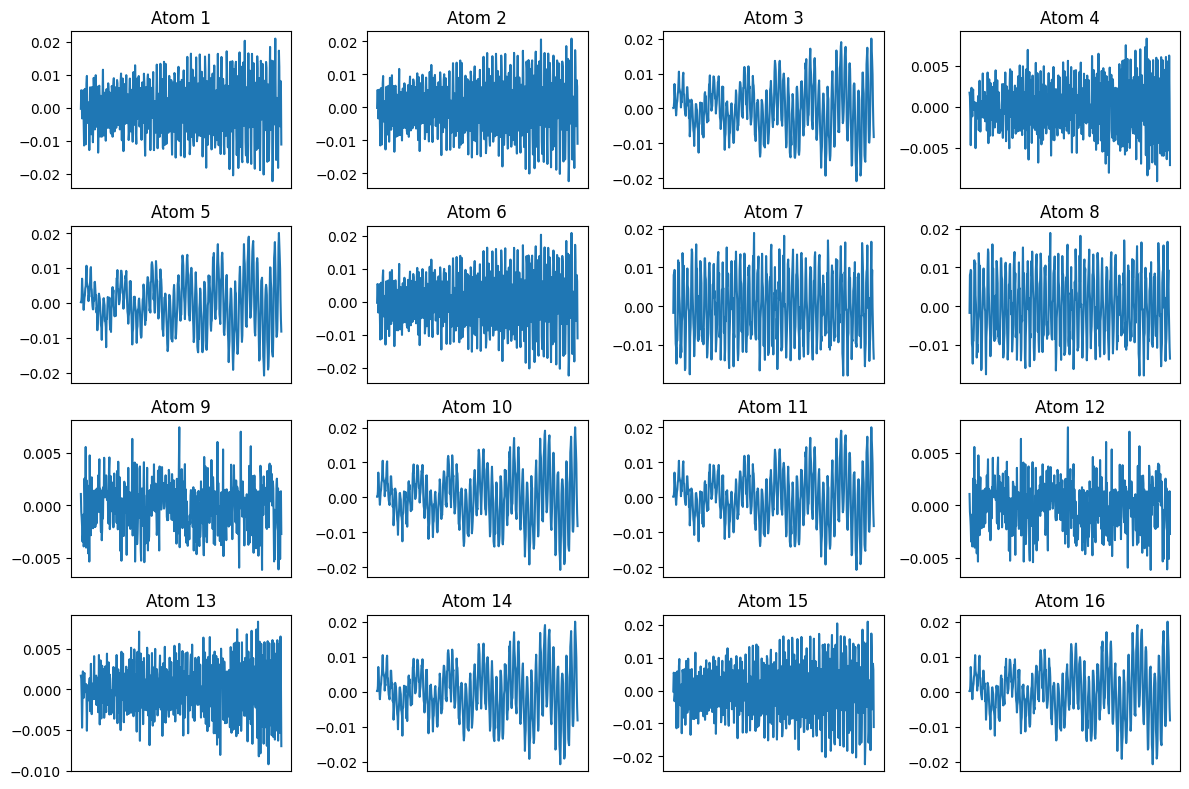

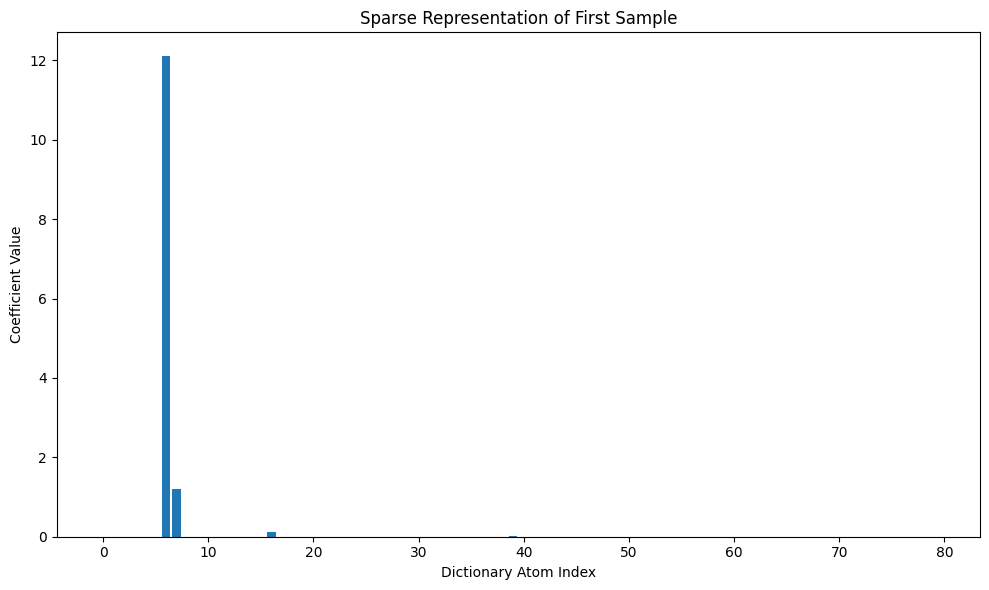

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import DictionaryLearning
from sklearn.preprocessing import normalize
import librosa


def gammatone_impulse_response(t, frequency, phase, order=4, bandwidth=1.019):
    """
    Generate gammatone filter impulse response.
    
    Parameters:
    -----------
    t : ndarray
        Time vector
    frequency : float
        Center frequency in Hz
    phase : float
        Phase in radians
    order : int
        Filter order
    bandwidth : float
        Bandwidth parameter (ERB scale)
        
    Returns:
    --------
    gt : ndarray
        Gammatone filter impulse response
    """
    erb = 24.7 * (4.37 * frequency / 1000 + 1)
    b = bandwidth * 2 * np.pi * erb
    
    # Gammatone impulse response formula
    gt = t**(order-1) * np.exp(-2 * np.pi * b * t) * np.cos(2 * np.pi * frequency * t + phase)
    
    return gt


def create_gammatone_dictionary(signal_length, sample_rate=16000, num_frequencies=40, 
                               num_phases=4, order=4, normalize_atoms=True):
    """
    Create a gammatone filter dictionary for time series data.
    
    Parameters:
    -----------
    signal_length : int
        Length of the time series signal
    sample_rate : int
        Sample rate of the signal in Hz
    num_frequencies : int
        Number of center frequencies for the gammatone filters
    num_phases : int
        Number of phases for the gammatone filters
    order : int
        Filter order
    normalize_atoms : bool
        Whether to normalize the dictionary atoms
        
    Returns:
    --------
    dictionary : ndarray, shape (n_atoms, signal_length)
        Gammatone filter dictionary
    frequencies : ndarray
        Center frequencies used in the dictionary
    """
    # Calculate number of atoms
    n_atoms = num_frequencies * num_phases
    
    # Create empty dictionary
    dictionary = np.zeros((n_atoms, signal_length))
    
    # Generate frequencies using ERB scale (mimics human auditory system)
    min_freq = 50  # Hz
    max_freq = sample_rate / 2 - 100  # Hz, slightly below Nyquist
    
    # Use ERB scale for frequency spacing
    frequencies = librosa.core.mel_frequencies(
        n_mels=num_frequencies,
        fmin=min_freq,
        fmax=max_freq,
        htk=True
    )
    
    # Generate phases
    phases = np.linspace(0, 2*np.pi, num_phases, endpoint=False)
    
    # Time vector (in seconds)
    t = np.arange(signal_length) / sample_rate
    
    # Generate gammatone atoms
    atom_idx = 0
    for freq in frequencies:
        for phase in phases:
            # Create gammatone atom
            gt_atom = gammatone_impulse_response(t, freq, phase, order=order)
            
            # Store atom in dictionary
            dictionary[atom_idx] = gt_atom
            atom_idx += 1
    
    # Normalize dictionary atoms if requested
    if normalize_atoms:
        dictionary = normalize(dictionary, axis=1, norm='l2')
    
    return dictionary, frequencies


def fit_dictionary_to_timeseries(time_series, dictionary=None, n_components=None, 
                                sample_rate=16000, alpha=1.0, 
                                transform_algorithm='lasso_lars'):
    """
    Fit a gammatone dictionary to time series data using dictionary learning.
    
    Parameters:
    -----------
    time_series : ndarray, shape (n_samples, signal_length)
        Input time series data
    dictionary : ndarray or None
        Initial dictionary to start with. If None, a gammatone dictionary is created.
    n_components : int or None
        Number of dictionary atoms to use. If None, use min(n_samples, signal_length)
    sample_rate : int
        Sample rate of the signal in Hz
    alpha : float
        Sparsity controlling parameter
    transform_algorithm : str
        Algorithm for sparse coding
        
    Returns:
    --------
    dictionary : ndarray
        Learned dictionary
    sparse_code : ndarray
        Sparse representation of the input data
    reconstructed : ndarray
        Reconstructed time series using the learned dictionary
    frequencies : ndarray or None
        Center frequencies used (if gammatone dictionary is created)
    """
    n_samples, signal_length = time_series.shape
    
    # Create gammatone dictionary if not provided
    frequencies = None
    if dictionary is None:
        if n_components is None:
            n_components = min(n_samples, signal_length)
        
        # Calculate optimal number of frequencies and phases
        num_frequencies = int(np.sqrt(n_components))
        num_phases = n_components // num_frequencies
        
        dictionary, frequencies = create_gammatone_dictionary(
            signal_length, 
            sample_rate=sample_rate,
            num_frequencies=num_frequencies,
            num_phases=num_phases,
            order=4
        )
        
        # If the dictionary is too large, truncate it
        if dictionary.shape[0] > n_components:
            dictionary = dictionary[:n_components]
    
    # Initialize dictionary learning
    dict_learner = DictionaryLearning(
        n_components=n_components or dictionary.shape[0],
        alpha=alpha,
        max_iter=1000,
        transform_algorithm=transform_algorithm,
        fit_algorithm='cd',
        dict_init=dictionary,
        verbose=False
    )
    
    # Fit dictionary and transform data
    sparse_code = dict_learner.fit_transform(time_series)
    
    # Get the learned dictionary
    learned_dictionary = dict_learner.components_
    
    # Reconstruct time series
    reconstructed = sparse_code @ learned_dictionary
    
    return learned_dictionary, sparse_code, reconstructed, frequencies


def analyze_spectrogram(time_series, sample_rate=16000, n_fft=512, hop_length=128):
    """
    Compute spectrogram of time series for visualization.
    
    Parameters:
    -----------
    time_series : ndarray
        Input time series (1D)
    sample_rate : int
        Sample rate of the signal in Hz
    n_fft : int
        FFT window size
    hop_length : int
        Hop length for STFT
        
    Returns:
    --------
    S : ndarray
        Spectrogram magnitude
    frequencies : ndarray
        Frequency bins
    times : ndarray
        Time frames
    """
    # Compute spectrogram
    S = librosa.stft(time_series, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    # Get frequency and time axes
    frequencies = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
    times = librosa.times_like(S, sr=sample_rate, hop_length=hop_length)
    
    return S_db, frequencies, times


def demo_with_synthetic_data(n_samples=5, signal_length=8000, sample_rate=16000):
    """
    Demonstrate gammatone dictionary fitting with synthetic data.
    """
    # Generate synthetic time series data with multiple frequency components
    np.random.seed(42)
    t = np.arange(signal_length) / sample_rate
    
    # Create sample signals with different frequency components
    signals = []
    for _ in range(n_samples):
        # Random frequency components
        freqs = np.random.choice(np.linspace(200, 4000, 10), size=3)
        amplitudes = np.random.rand(3)
        durations = np.random.rand(3) * 0.2 + 0.1  # 0.1 to 0.3 seconds
        start_times = np.random.rand(3) * (t[-1] - durations.max())
        
        # Create signal with noise
        signal = np.zeros(signal_length)
        for i in range(3):
            # Create a gammatone-like component
            env = np.exp(-(t - start_times[i])**2 / (2 * (durations[i]/4)**2))
            wave = np.sin(2 * np.pi * freqs[i] * t)
            signal += amplitudes[i] * env * wave
        
        # Add Gaussian noise
        signal += 0.05 * np.random.randn(signal_length)
        signals.append(signal)
    
    # Stack signals
    time_series = np.vstack(signals)
    
    # Create and fit gammatone dictionary
    dictionary, freqs = create_gammatone_dictionary(
        signal_length,
        sample_rate=sample_rate,
        num_frequencies=20,
        num_phases=4
    )
    
    learned_dict, sparse_code, reconstructed, _ = fit_dictionary_to_timeseries(
        time_series, dictionary=dictionary, alpha=0.5, sample_rate=sample_rate
    )
    
    # Calculate reconstruction error
    error = np.mean((time_series - reconstructed) ** 2)
    print(f"Mean squared reconstruction error: {error:.6f}")
    
    # Plot original vs reconstructed signals for the first example
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3, 1, 1)
    plt.title("Original Signal (First Example)")
    plt.plot(t, time_series[0])
    plt.xlabel("Time (s)")
    
    plt.subplot(3, 1, 2)
    plt.title("Reconstructed Signal (First Example)")
    plt.plot(t, reconstructed[0])
    plt.xlabel("Time (s)")
    
    plt.subplot(3, 1, 3)
    plt.title("Reconstruction Error")
    plt.plot(t, time_series[0] - reconstructed[0])
    plt.xlabel("Time (s)")
    
    plt.tight_layout()
    plt.show()
    
    # Display spectrogram of original and reconstructed signal
    plt.figure(figsize=(14, 10))
    
    # Original spectrogram
    S_orig, f_orig, t_orig = analyze_spectrogram(time_series[0], sample_rate)
    plt.subplot(2, 1, 1)
    plt.title("Spectrogram of Original Signal")
    plt.pcolormesh(t_orig, f_orig, S_orig, cmap='viridis', shading='gouraud')
    plt.colorbar(label='Amplitude (dB)')
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    
    # Reconstructed spectrogram
    S_recon, f_recon, t_recon = analyze_spectrogram(reconstructed[0], sample_rate)
    plt.subplot(2, 1, 2)
    plt.title("Spectrogram of Reconstructed Signal")
    plt.pcolormesh(t_recon, f_recon, S_recon, cmap='viridis', shading='gouraud')
    plt.colorbar(label='Amplitude (dB)')
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    
    plt.tight_layout()
    plt.show()
    
    # Display the learned dictionary atoms
    num_atoms_to_display = min(16, learned_dict.shape[0])
    plt.figure(figsize=(12, 8))
    for i in range(num_atoms_to_display):
        plt.subplot(4, 4, i+1)
        plt.plot(t[:500], learned_dict[i][:500])  # Show just beginning for clarity
        plt.title(f"Atom {i+1}")
        plt.xticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Visualize sparse code for first sample
    plt.figure(figsize=(10, 6))
    plt.title("Sparse Representation of First Sample")
    plt.bar(range(sparse_code.shape[1]), sparse_code[0])
    plt.xlabel("Dictionary Atom Index")
    plt.ylabel("Coefficient Value")
    plt.tight_layout()
    plt.show()
    
    return dictionary, learned_dict, sparse_code, reconstructed


def fit_gammatone_to_real_timeseries(time_series_data, sample_rate=16000, signal_length=None):
    """
    Fit gammatone dictionary to real time series data.
    
    Parameters:
    -----------
    time_series_data : ndarray, 1D or 2D
        Input time series data. If 1D, it will be reshaped to 2D.
    sample_rate : int
        Sample rate of the signal in Hz
    signal_length : int or None
        Length to reshape the signal. If None, use the original length.
    
    Returns:
    --------
    Dictionary fitting results.
    """
    # Reshape time series if necessary
    if time_series_data.ndim == 1:
        if signal_length is None:
            signal_length = len(time_series_data)
        
        # Calculate how many samples we can extract
        n_samples = len(time_series_data) // signal_length
        
        # Reshape the data
        reshaped_data = np.array([
            time_series_data[i*signal_length:(i+1)*signal_length] 
            for i in range(n_samples)
        ])
    else:
        reshaped_data = time_series_data
    
    # Create and fit gammatone dictionary
    dictionary, freqs = create_gammatone_dictionary(
        reshaped_data.shape[1],
        sample_rate=sample_rate,
        num_frequencies=20,
        num_phases=4
    )
    
    learned_dict, sparse_code, reconstructed, _ = fit_dictionary_to_timeseries(
        reshaped_data, 
        dictionary=dictionary, 
        alpha=0.5,
        sample_rate=sample_rate
    )
    
    return dictionary, learned_dict, sparse_code, reconstructed


def gammatone_filterbank_visualization(frequencies, sample_rate=16000, signal_length=8000):
    """
    Visualize the gammatone filterbank for a range of frequencies.
    
    Parameters:
    -----------
    frequencies : ndarray
        Center frequencies for gammatone filters
    sample_rate : int
        Sample rate in Hz
    signal_length : int
        Length of the time series signal
    """
    t = np.arange(signal_length) / sample_rate
    order = 4
    
    # Create grid for plotting
    num_freqs = len(frequencies)
    plt.figure(figsize=(12, 8))
    
    # Plot time domain responses
    plt.subplot(2, 1, 1)
    plt.title("Time Domain Gammatone Filter Responses")
    for i, freq in enumerate(frequencies[::max(1, num_freqs//10)]):  # Plot subset for clarity
        gt = gammatone_impulse_response(t, freq, phase=0, order=order)
        gt_norm = gt / np.max(np.abs(gt))  # Normalize
        plt.plot(t[:800], gt_norm[:800] + i*0.5)  # Show just beginning for clarity
    
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True, alpha=0.3)
    
    # Plot frequency responses
    plt.subplot(2, 1, 2)
    plt.title("Frequency Domain Gammatone Filter Responses")
    
    for freq in frequencies:
        gt = gammatone_impulse_response(t, freq, phase=0, order=order)
        
        # Compute frequency response
        freqs, resp = signal.freqz(gt, worN=2048)
        freqs = freqs * sample_rate / (2 * np.pi)
        
        # Plot magnitude response (normalize)
        plt.plot(freqs, np.abs(resp) / np.max(np.abs(resp)))
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Magnitude")
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.xlim([50, sample_rate/2])
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Run the demo
    demo_with_synthetic_data()

In [ ]:
plt.figure(figsize=(12, 8))

t = np.arange(wave_mat1.shape[1])
time_series = wave_mat1

plt.subplot(3, 1, 1)
plt.title("Original Signal (First Example)")
plt.plot(t, time_series[0])
plt.xlabel("Time (s)")
    
plt.subplot(3, 1, 2)
plt.title("Reconstructed Signal (First Example)")
plt.plot(t, reconstructed[0])
plt.xlabel("Time (s)")
    
plt.subplot(3, 1, 3)
plt.title("Reconstruction Error")
plt.plot(t, time_series[0] - reconstructed[0])
plt.xlabel("Time (s)")
    
plt.tight_layout()
plt.show()

In [ ]:
t = np.arange(wave_mat1.shape[1])
t.shape

In [ ]:
import numpy as np

# Load your time series data
# time_series = np.load('your_time_series.npy')  # or read from CSV, etc.
wave_mat1 = wav_matrix[0:1, 0:60000]

# # Fit Gabor dictionary - adjust signal_length as needed for your data
# dictionary, learned_dict, sparse_code, reconstructed = fit_gabor_to_real_timeseries(
#     wave_mat1, signal_length=512)

# # Evaluate reconstruction error
# error = np.mean((wave_mat1 - reconstructed) ** 2)
# print(f"Mean squared reconstruction error: {error:.6f}")

In [ ]:
time_series = wave_mat1

In [ ]:
plt.figure(figsize=(12, 8))
    
plt.subplot(3, 1, 1)
plt.title("Original Signal (First Example)")
plt.plot(time_series[0])
    
plt.subplot(3, 1, 2)
plt.title("Reconstructed Signal (First Example)")
plt.plot(reconstructed[0])
    
plt.subplot(3, 1, 3)
plt.title("Reconstruction Error")
plt.plot(time_series[0] - reconstructed[0])
    
plt.tight_layout()
plt.show()
    
    # Display the learned dictionary atoms
num_atoms_to_display = min(16, learned_dict.shape[0])
plt.figure(figsize=(12, 8))
for i in range(num_atoms_to_display):
    plt.subplot(4, 4, i+1)
    plt.plot(learned_dict[i])
    plt.title(f"Atom {i+1}")
    plt.xticks([])
    
plt.tight_layout()
plt.show()
    
    # Analyze first signal using wavelet transform for comparison
coefficients, frequencies = analyze_wavelet_coefficients(time_series[0])
    
plt.figure(figsize=(10, 6))
plt.title("Wavelet Coefficients (Scalogram)")
plt.imshow(np.abs(coefficients), aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.ylabel('Scale')
plt.xlabel('Time')
plt.tight_layout()
plt.show()